## Business Object
* Build Predictive maintenance models to predict the probability of device failure based on a year’s worth of data.
* Which can help determine wheather or not a maintenance should be performed to the in-service equipment . 

## Data exploration

### Import moduels

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
#xgb=XGBClassifier()
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import xgboost as xgb

### Import data as a dataframe

In [2]:
df = pd.read_csv('failures_prediction.csv')

In [3]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


### Check the data infos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [6]:
#no missing values
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [7]:
#imbalanced classification problem
df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

In [8]:
#no duplicated observations
df.duplicated().sum()

0

In [9]:
#output number of unique values for each column,
#7 attributes have very high percentage of zero values. 
#These could be error codes or some other indicator, I will change their data types later.
cols = df.columns
for col in cols:
    print(col)
    print(df[col].nunique())

date
304
device
1168
failure
2
attribute1
123878
attribute2
558
attribute3
47
attribute4
115
attribute5
60
attribute6
44838
attribute7
28
attribute8
28
attribute9
65


In [10]:
df.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
       'attribute9'],
      dtype='object')

In [11]:
#for col in ['attribute1', 'attribute2', 'attribute3',
#       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
#       'attribute9']:
#sns.lmplot(x='attribute1',y='failure',data=df,logistic=True,y_jitter=.03)

### Data visualization

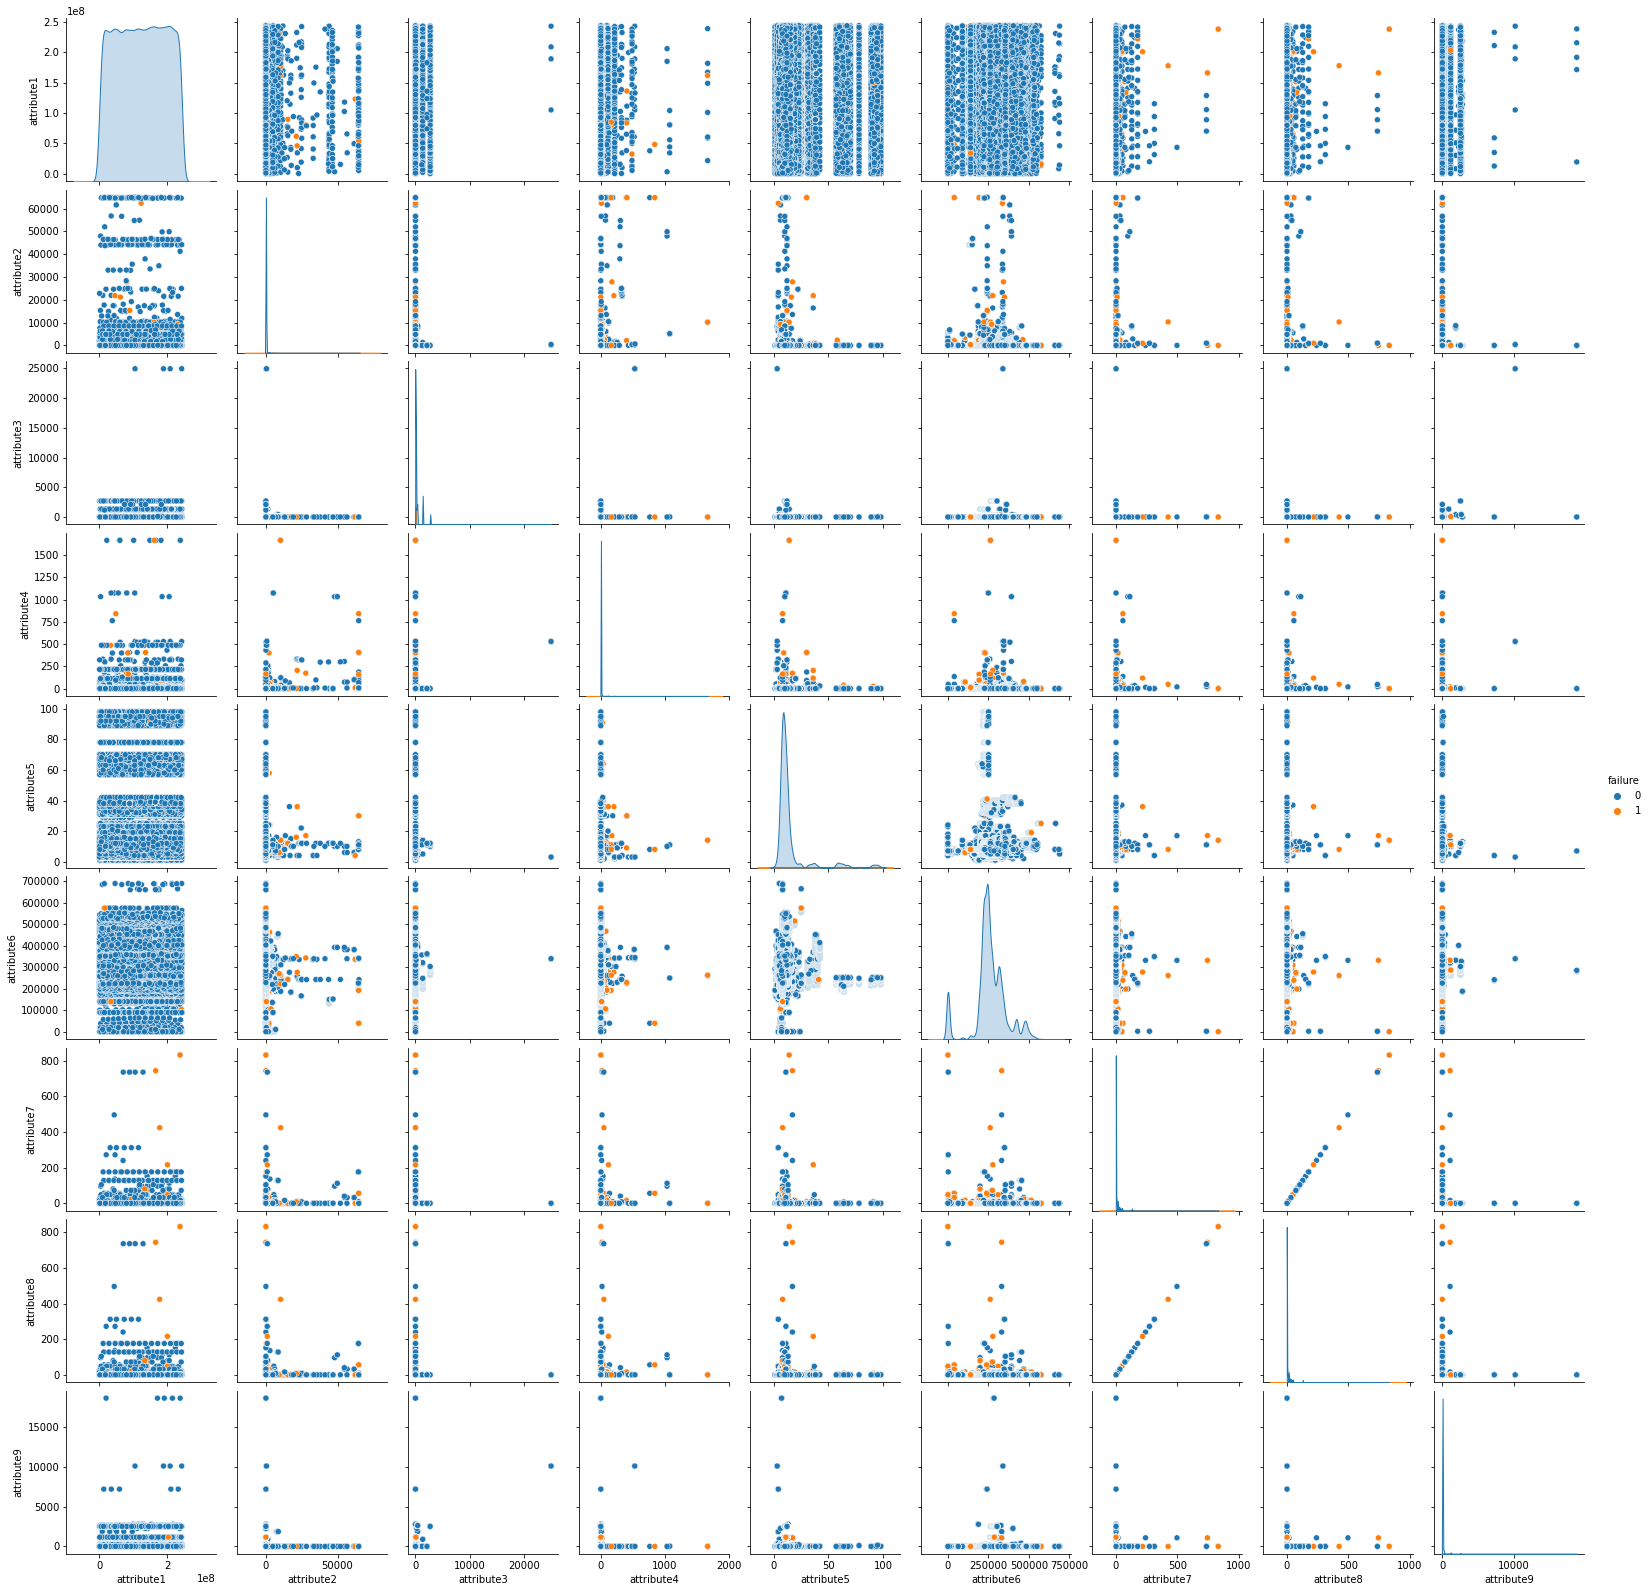

In [12]:
# pair plot to see feature correlations with each other
sns.pairplot(df,hue='failure')

It is obvious that attribute7 and attribut8 is highly linear related or equal to each other

### Summary

* This dataset is clean, no missing values. All attributes are integer data type.
* It is imbalanced data set, as the failuer class is about 0.1% of unfailure class.Here oversampling approach is used to deal with imbalanced dataset.
* Some attributes have limited number of distictive values, very sparse, indicating that they are likely to be categorical variable, such as attibute 3, 5,7,9.
* Attribue7 and 8 seems like exactly same to each other, we can drop one of them.

## Data Processing

### Drop unimportant features

In [13]:
# check if the two features are same
(df['attribute7']==df['attribute8']).value_counts()

True    124494
dtype: int64

In [14]:
# then I drop attribute 8, as it is duplicated.
df.drop('attribute8',axis=1,inplace=True)

In [15]:
df.drop('date',axis=1,inplace=True)

In [16]:
df.head()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


### Redefine data types

In [17]:
# redefine data type for some of the numerical features
cat_ftrs = ['attribute3','attribute4', 'attribute5', 'attribute7', 'attribute9']
for col in cat_ftrs:
    df[col]=df[col].astype('object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   device      124494 non-null  object
 1   failure     124494 non-null  int64 
 2   attribute1  124494 non-null  int64 
 3   attribute2  124494 non-null  int64 
 4   attribute3  124494 non-null  object
 5   attribute4  124494 non-null  object
 6   attribute5  124494 non-null  object
 7   attribute6  124494 non-null  int64 
 8   attribute7  124494 non-null  object
 9   attribute9  124494 non-null  object
dtypes: int64(4), object(6)
memory usage: 9.5+ MB


### Create device maintanance times as new feature

In [19]:
# group by device,the size means the mantainance times for each device. sum actually means
# same thing with original failure feature.
check_cnt_df = df.groupby('device').agg({'failure':[np.size,np.sum]})

In [20]:
check_cnt_df.head()

failure    
            size sum
device              
S1F01085       6   0
S1F013BB       6   0
S1F0166B       6   0
S1F01E6Y      48   0
S1F01JE0       6   0

In [21]:
check_cnt_df.columns

MultiIndex([('failure', 'size'),
            ('failure',  'sum')],
           )

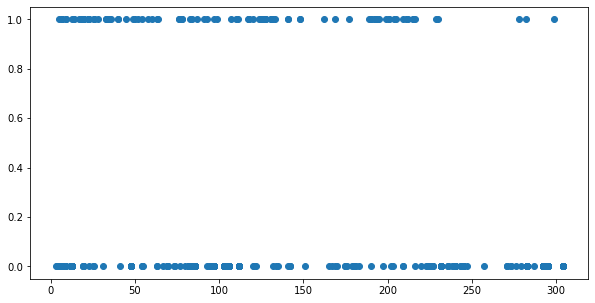

In [22]:
# from this plot, we see that the devices that fail come with 
#less maintanance times(up left scatter), devices not fail come with more maintancance times
#(up right scatter)
plt.figure(figsize=(10,5))
plt.scatter(check_cnt_df[('failure','size')],check_cnt_df[('failure','sum')])

In [23]:
#merge with df
df=df.merge(check_cnt_df,on='device',how='left')

/home/vijay/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


In [24]:
df.head()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,"(failure, size)","(failure, sum)"
0,S1F01085,0,215630672,56,0,52,6,407438,0,7,6,0
1,S1F0166B,0,61370680,0,3,0,6,403174,0,0,6,0
2,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,48,0
3,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,6,0
4,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,223,0


In [25]:
df.shape

(124494, 12)

In [26]:
(df['failure']==df[('failure','sum')]).value_counts()

True     113887
False     10607
dtype: int64

In [27]:
df.drop(('failure','sum'),axis=1,inplace=True)

### Redefine device Id value

In [28]:
#take a look at the device Id, the first four charachers are unique
df.device

0         S1F01085
1         S1F0166B
2         S1F01E6Y
3         S1F01JE0
4         S1F01R2B
            ...   
124489    Z1F0MA1S
124490    Z1F0Q8RT
124491    Z1F0QK05
124492    Z1F0QL3N
124493    Z1F0QLC1
Name: device, Length: 124494, dtype: object

In [29]:
Id = df.device.values.tolist()

In [30]:
#change device id values to the first four characters
Id1 = []
for i in Id:
    i = i[:4]
    Id1.append(i)

In [31]:
df.device=Id1

In [32]:
df.head()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,"(failure, size)"
0,S1F0,0,215630672,56,0,52,6,407438,0,7,6
1,S1F0,0,61370680,0,3,0,6,403174,0,0,6
2,S1F0,0,173295968,0,0,0,12,237394,0,0,48
3,S1F0,0,79694024,0,0,0,6,410186,0,0,6
4,S1F0,0,135970480,0,0,0,15,313173,0,3,223


<AxesSubplot:>

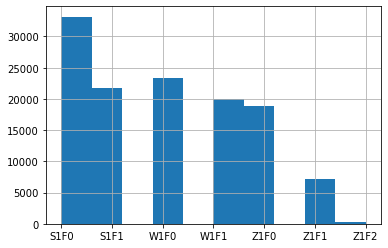

In [33]:
df.device.hist()

In [34]:
# after redefine the device id, we got 7 unique ids
df.device.value_counts()

S1F0    33169
W1F0    23294
S1F1    21689
W1F1    19974
Z1F0    18869
Z1F1     7248
Z1F2      251
Name: device, dtype: int64

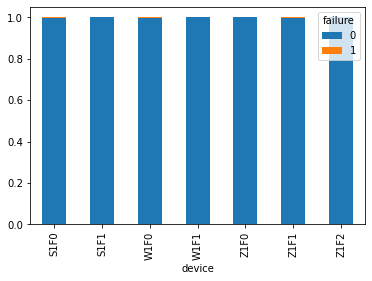

In [35]:
#device id start with S1F0,W1F1 and Z1F1 seem to have bigger chance to fail
dev=pd.crosstab(df['device'],df['failure']) 
dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.show() 

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124494 entries, 0 to 124493
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   device           124494 non-null  object
 1   failure          124494 non-null  int64 
 2   attribute1       124494 non-null  int64 
 3   attribute2       124494 non-null  int64 
 4   attribute3       124494 non-null  object
 5   attribute4       124494 non-null  object
 6   attribute5       124494 non-null  object
 7   attribute6       124494 non-null  int64 
 8   attribute7       124494 non-null  object
 9   attribute9       124494 non-null  object
 10  (failure, size)  124494 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 11.4+ MB


### Extract outliers for numerical features

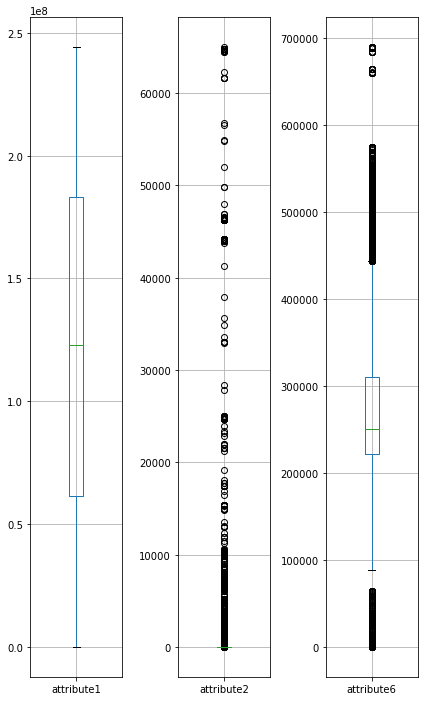

In [37]:
fig = plt.figure(figsize=(6,10))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

df.boxplot(column='attribute1', ax=ax1)
df.boxplot(column='attribute2', ax=ax2)
df.boxplot(column='attribute6', ax=ax3)

plt.suptitle('')
plt.tight_layout()

In [38]:
# take 5% of the top values as outliers
outliers = df.quantile(0.95)
outliers

num_ftrs =['attribute1','attribute2','attribute6']

for i in num_ftrs:
    df1=df[(df[i]<outliers[i])]

df1.shape

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118269 entries, 0 to 124493
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   device           118269 non-null  object
 1   failure          118269 non-null  int64 
 2   attribute1       118269 non-null  int64 
 3   attribute2       118269 non-null  int64 
 4   attribute3       118269 non-null  object
 5   attribute4       118269 non-null  object
 6   attribute5       118269 non-null  object
 7   attribute6       118269 non-null  int64 
 8   attribute7       118269 non-null  object
 9   attribute9       118269 non-null  object
 10  (failure, size)  118269 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 10.8+ MB


### Data transformation

* Numerical features normalization

Text(0.5, 1.0, 'Log-Transformed Distribution')

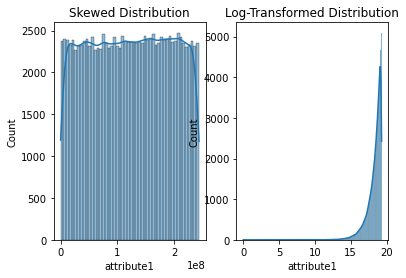

In [39]:
f, axarr = plt.subplots(1,2)
sns.histplot(df1['attribute1'],ax=axarr[0],kde=True)
axarr[0].set_title('Skewed Distribution')
sns.histplot(np.log(1+df1['attribute1']),ax=axarr[1],kde=True)
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

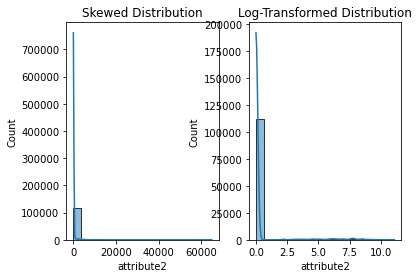

In [40]:
f, axarr = plt.subplots(1,2)
sns.histplot(df1['attribute2'],ax=axarr[0],kde=True)
axarr[0].set_title('Skewed Distribution')
sns.histplot(np.log(1+df1['attribute2']),ax=axarr[1],kde=True)
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

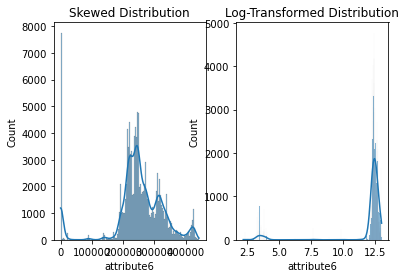

In [41]:
f, axarr = plt.subplots(1,2)
sns.histplot(df1['attribute6'],ax=axarr[0],kde=True)
axarr[0].set_title('Skewed Distribution')
sns.histplot(np.log(1+df1['attribute6']),ax=axarr[1],kde=True)
axarr[1].set_title('Log-Transformed Distribution')

* numerical features standardization

In [42]:
df1[num_ftrs]=scaler.fit_transform(df1[num_ftrs])

<ipython-input-42-995a33369077>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[num_ftrs]=scaler.fit_transform(df1[num_ftrs])
/home/vijay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [43]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118269 entries, 0 to 124493
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   device           118269 non-null  object 
 1   failure          118269 non-null  int64  
 2   attribute1       118269 non-null  float64
 3   attribute2       118269 non-null  float64
 4   attribute3       118269 non-null  object 
 5   attribute4       118269 non-null  object 
 6   attribute5       118269 non-null  object 
 7   attribute6       118269 non-null  float64
 8   attribute7       118269 non-null  object 
 9   attribute9       118269 non-null  object 
 10  (failure, size)  118269 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 10.8+ MB


* get dummies on categorical feature

In [44]:
df1 = pd.get_dummies(df1,drop_first=True)

In [45]:
df1.shape

(118269, 315)

## Feature Selection

### Define dependent and independent values

In [46]:
X = df1.drop('failure',axis=1)
Y = df1['failure']

In [47]:
type(Y)

pandas.core.series.Series

<AxesSubplot:ylabel='feature'>

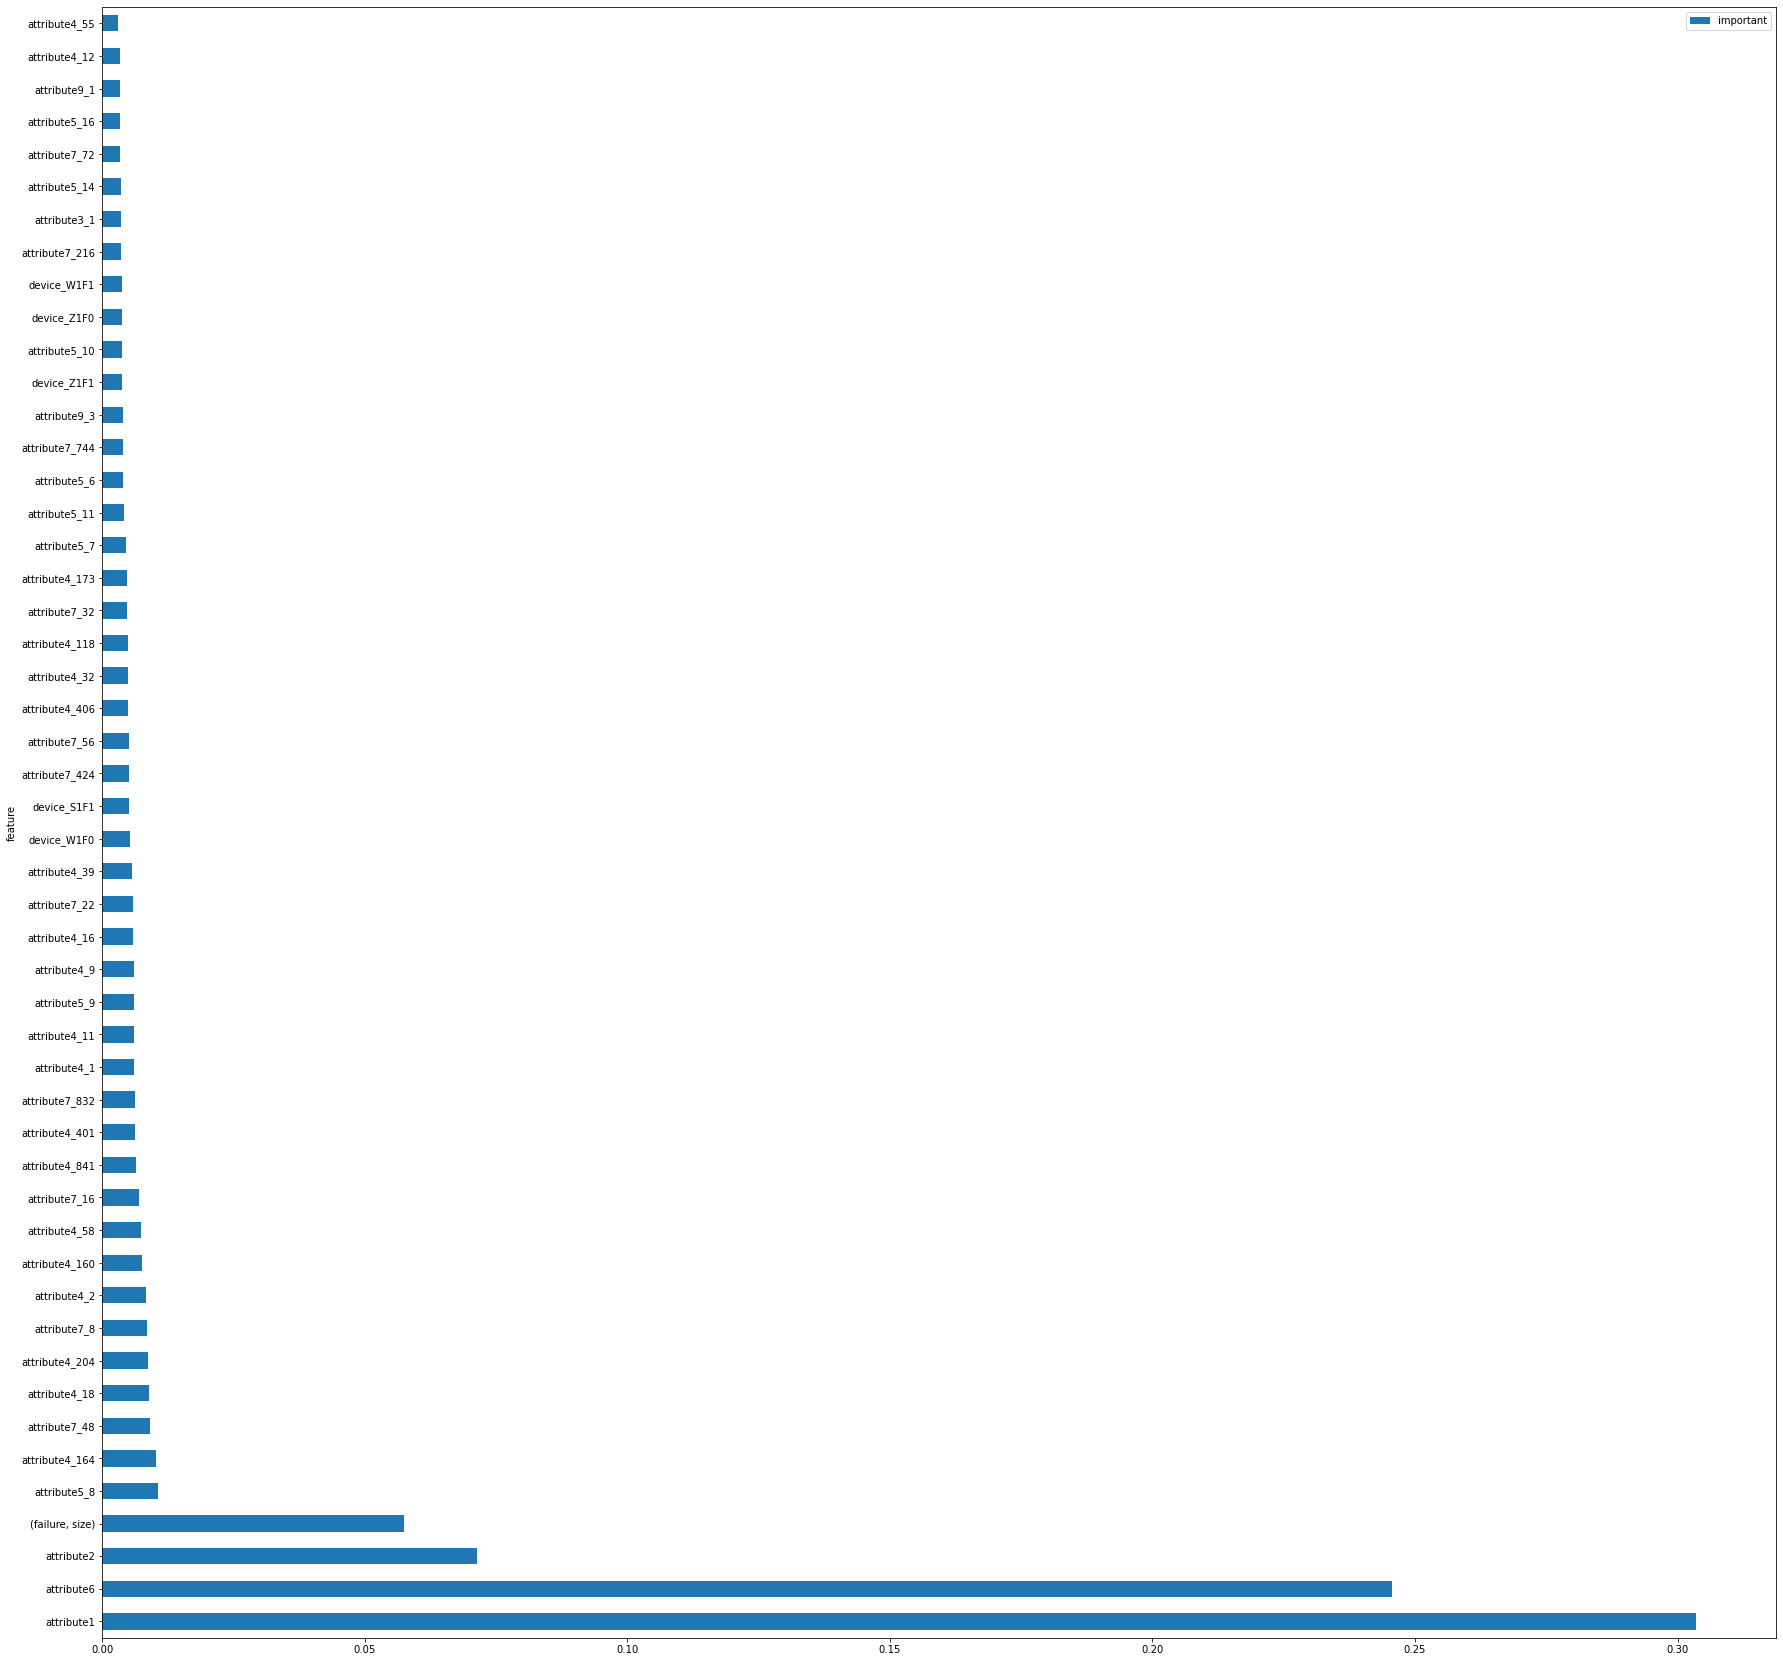

In [48]:
clf = RandomForestClassifier(n_estimators=50, max_features='auto')
clf= clf.fit(X,Y)

features = pd.DataFrame()
features['feature']= X.columns
features['important']=clf.feature_importances_
features.sort_values(by=['important'], ascending=False,inplace=True)
features.set_index('feature', inplace=True)
features.iloc[:50,:].plot(kind='barh', figsize=(30,30))

In [49]:
model = SelectFromModel(clf,prefit=True)
x_reduced = model.transform(X)
print (x_reduced.shape)


(118269, 49)


In [50]:
type(x_reduced)

numpy.ndarray

In [51]:
print(np.any(np.isnan(x_reduced)))

False


In [52]:
print(np.all(np.isfinite(x_reduced)))

True


In [53]:
Y = Y.astype(np.float)

<ipython-input-53-3ff2ec12d0a2>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = Y.astype(np.float)


In [54]:
x_reduced

array([[ 1.32397975, -0.04943664,  1.83595429, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86624495, -0.07451142,  1.78675012, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72290028, -0.07451142, -0.12625834, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.46742176,  2.08908367,  1.17788307, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48474299, -0.07451142,  1.27677608, ...,  0.        ,
         0.        ,  0.        ],
       [-1.48809842, -0.07451142,  1.18966484, ...,  0.        ,
         0.        ,  0.        ]])

In [55]:
Y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
124489    0.0
124490    0.0
124491    0.0
124492    0.0
124493    0.0
Name: failure, Length: 118269, dtype: float64

### Resample data set
when encounter with imbalanced dataset, we always re-sample the data in order to mitigate the effect caused by class imbalance. The two most common techniques are over-sampling and under-sampling. Here I used under-sampling as the dataset is little big.

In [56]:
# import model for imbalanced data set
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced
from sklearn.metrics import confusion_matrix

In [58]:
# tested on RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x_reduced, Y, train_size=0.8, \
                                                    random_state=42)


rus = RandomUnderSampler(random_state=42)


X_res, y_res = rus.fit_resample(X_train, y_train)
X_res.shape
X_res = pd.DataFrame(X_res)


rf = RandomForestClassifier(n_estimators=5000, random_state=21)

a = rf.fit(X_res,y_res)



rf_test_pred = rf.predict(X_test)
rf_test_cm = confusion_matrix(y_test, rf_test_pred)
rf_test_cm

array([[21027,  2609],
       [    5,    13]])

In [59]:
rf_test_cm

accuracy_score(y_test, rf_test_pred)

print(classification_report_imbalanced(y_test,rf_test_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.89      0.72      0.94      0.80      0.65     23636
        1.0       0.00      0.72      0.89      0.01      0.80      0.63        18

avg / total       1.00      0.89      0.72      0.94      0.80      0.65     23654



* pre is precision, which is a measure of result relevancy;
* rec is recall, which is the same as sensitivity. Recall is a measure of how many truly relevant results are returned;
* spe is specificity;
* f1 is the harmonic average of the precision and recall;
* geo(Matthews correlation coefficient) is the geometric mean of specificity and sensitivity;
* iba is the index of imbalanced accuracy

## Model Training

In [60]:
log=LogisticRegression()
k=KNeighborsClassifier()
gbc =GradientBoostingClassifier()
rgr = RandomForestRegressor(n_estimators=100)
svc = SVC()
rfc = RandomForestClassifier(n_estimators=10)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
algorithms=[k,log,gbc,rgr,svc,rfc,xg_reg]
names=['KNeighborsClassifier','Logistic','GradientBoost','RandomForest','SVC','RandomForestCl','xgboost']

In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
#import xgboost as xgb

In [62]:
#ni
#ni
#ni

In [63]:
type(x_reduced),type(Y)

(numpy.ndarray, pandas.core.series.Series)

In [66]:
from sklearn.model_selection import KFold
j=1
kf = KFold(n_splits=5,shuffle=True)
accuracy = []
for train_index,test_index in kf.split(x_reduced,Y):
            print('\n{} of kfold {}'.format(j,kf.n_splits))
            xtr,xvl = x_reduced[train_index],x_reduced[test_index]     
            ytr,yvl = Y[train_index],Y[test_index]         
            model = GradientBoostingClassifier(random_state=1)     
            model.fit(xtr, ytr)     
            pred_test = model.predict(xvl)     
            score = accuracy_score(yvl,pred_test)
            accuracy.append(score)
            print('accuracy_score',score)
            j=j+1
print(np.mean(accuracy))


1 of kfold 5


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([     7,    117,    119,    123,    535,\n            ...\n            118202, 118203, 118205, 118243, 118244],\n           dtype='int64', length=4334). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
def cross_validation_fit_predict(x_reduced,Y,algorithms = algorithms, names = names):
    # fit the data
    # print metrics
    Geo_score = []
    Iba_score = []
    Accuracy = []
    F1=[]
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
        geo_score = []
        iba_score = []
        accuracy = []
        f1=[]
        for train_index,test_index in kf.split(x_reduced,Y,):
            '\n{} of kfold {}'.format(j,kf.n_splits)
            xtr,xvl = x_reduced[train_index],x_reduced[test_index]     
            ytr,yvl = Y[train_index],Y[test_index]
            X_res, y_res = rus.fit_sample(xtr, ytr)
            algorithms[i] = algorithms[i].fit(X_res, y_res)  
            pred_test = algorithms[i].predict(xvl)     
            accuracy.append(accuracy_score(yvl, algorithms[i].predict(xvl).round()))
            geo_score.append(geo(yvl, algorithms[i].predict(xvl).round()))
            iba_score.append(iba(yvl, algorithms[i].predict(xvl).round()))
            f1.append(f1_score(yvl, algorithms[i].predict(xvl).round(),average='macro'))
            j+=1
        mean_ac = np.mean(accuracy)
        mean_f1 = np.mean(f1)
        mean_geo=np.mean(geo_score)
        mean_iba=np.mean(iba_score)
        F1.append(mean_f1)
        Geo_score.append(mean_geo)
        Iba_score.append(mean_iba)
        Accuracy.append(mean_ac)
    metrics = pd.DataFrame(columns = ['Accuracy', 'F1','Geo','Iba'], index = names)
    metrics['F1'] = F1
    metrics['Accuracy'] = Accuracy
    metrics['Geo']=Geo_score
    metrics['Iba']=Iba_score
    return metrics.sort_values('Geo', ascending = False)

In [273]:
from sklearn.model_selection import StratifiedKFold

def cross_validation_fit_predict(X_res, y_res, algorithms = algorithms, names = names):
    # fit the data
    # print metrics
    Geo_score = []
    Iba_score = []
    Accuracy = []
    F1=[]
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
        geo_score = []
        iba_score = []
        accuracy = []
        f1=[]
        for train_index,test_index in kf.split(X_res, y_res):
            '\n{} of kfold {}'.format(j,kf.n_splits)
            xtr,xvl = x_reduced[train_index],x_reduced[test_index]     
            ytr,yvl = Y[train_index],Y[test_index]
            algorithms[i] = algorithms[i].fit(xtr, ytr)  
            pred_test = algorithms[i].predict(xvl)     
            accuracy.append(accuracy_score(yvl, algorithms[i].predict(xvl).round()))
            geo_score.append(geo(yvl, algorithms[i].predict(xvl).round()))
            iba_score.append(iba(yvl, algorithms[i].predict(xvl).round()))
            f1.append(f1_score(yvl, algorithms[i].predict(xvl).round(),average='macro'))
            j+=1
        mean_ac = np.mean(accuracy)
        mean_f1 = np.mean(f1)
        mean_geo=np.mean(geo_score)
        mean_iba=np.mean(iba_score)
        F1.append(mean_f1)
        Geo_score.append(mean_geo)
        Iba_score.append(mean_iba)
        Accuracy.append(mean_ac)
    metrics = pd.DataFrame(columns = ['Accuracy', 'F1','Geo','Iba'], index = names)
    metrics['F1'] = F1
    metrics['Accuracy'] = Accuracy
    metrics['Geo']=Geo_score
    metrics['Iba']=Iba_score
    return metrics.sort_values('Geo', ascending = False)

In [274]:
cross_validation_fit_predict(X_res, y_res, algorithms = algorithms, names = names)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

,Accuracy,F1,Geo,Iba
SVC,0.808208,0.450807,0.843481,0.712265
KNeighborsClassifier,0.842884,0.461796,0.835771,0.700850
GradientBoost,0.857655,0.466506,0.833363,0.696747
xgboost,0.868909,0.470093,0.833222,0.696577
RandomForest,0.858602,0.466675,0.823827,0.681106
RandomForestCl,0.871935,0.470424,0.782045,0.612327
Logistic,0.801469,0.447791,0.762840,0.588403


In [133]:
from imblearn.metrics import geometric_mean_score as geo
from imblearn.metrics import make_index_balanced_accuracy as iba
iba = make_index_balanced_accuracy(alpha=0.1, squared=True)(geo)

here is the link, why I choose geo and iba
https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/evaluation/plot_metrics.html#sphx-glr-auto-examples-evaluation-plot-metrics-py

In [59]:
#def imblearn_metrics(X_res, y_res, X_test, y_test, algorithms = algorithms, names = names):
#    # fit the data
#    #x_train_reduced, x_test_reduced, y_train, y_test = train_test_split(x_reduced,Y,test_size=0.1, random_state=13)
#    geo_score = []
#    iba_score = []
#    accuracy = []
#    f1=[]
#    for i in range(len(algorithms)):
#        algorithms[i] = algorithms[i].fit(X_res, y_res)
#        y_test_pred = algorithms[i].predict(X_test).round()
#        accuracy.append(accuracy_score(y_test, algorithms[i].predict(X_test).round()))
#        geo_score.append(geo(y_test, algorithms[i].predict(X_test).round()))
#        iba_score.append(iba(y_test, algorithms[i].predict(X_test).round()))
#        f1.append(f1_score(y_test, algorithms[i].predict(X_test).round(),average='macro'))
#        #cm=confusion_matrix(y_test,y_test_pred)
#        #print(cm)
#    metrics = pd.DataFrame(columns = ['Accuracy','geo_score','iba_score'],index=names)
#    metrics['Accuracy']=accuracy
#    metrics['geo_score']=geo_score
#    metrics['iba_score']=iba_score
#    metrics['f1']=f1
#    return metrics.sort_values('geo_score',ascending=False)

### Model evaluation

In [60]:
#imblearn_metrics(X_res, y_res, X_test, y_test, algorithms = algorithms, names = names)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Accuracy,geo_score,iba_score,f1
RandomForest,0.879006,0.883930,0.781332,0.473309
GradientBoost,0.871311,0.880050,0.774487,0.470792
RandomForestCl,0.897311,0.805080,0.648154,0.478218
Logistic,0.830557,0.803754,0.646020,0.457157
xgboost,0.820369,0.798805,0.638090,0.453902
SVC,0.816014,0.767721,0.589395,0.452282
KNeighborsClassifier,0.848440,0.720140,0.518602,0.462032


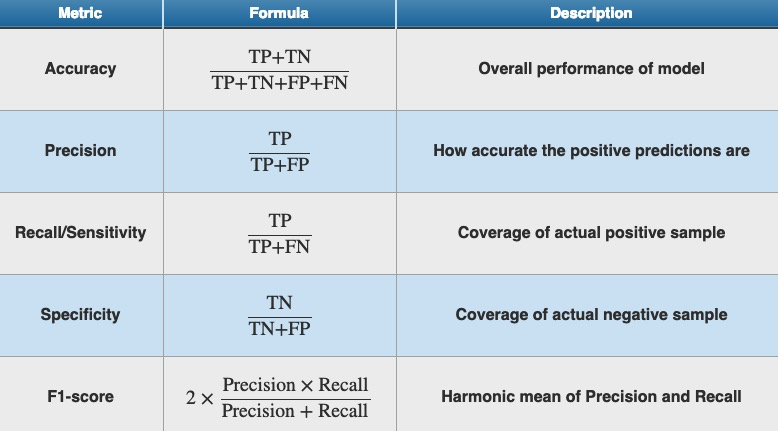

### Model tunning

In [118]:
param_test1 = [i for i in range(5,50,5)]
param_test1

[5, 10, 15, 20, 25, 30, 35, 40, 45]

In [150]:
#tune n_estimators
Geo1=[]
param_test1 = [i for i in range(50,200,30)]
for i in param_test1:
    gbc =GradientBoostingClassifier(n_estimators=i)
    gbc.fit(X_res,y_res)
    y_pred = gbc.predict(X_test).round()
    geo(y_test,y_pred)
    Geo1.append(geo(y_test, y_pred))

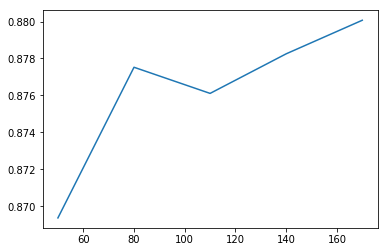

In [151]:
plt.plot(param_test1,Geo1)

In [139]:
#The best n_estimator is 80

In [186]:
#tune learning_rate
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,\
                max_depth = 5, alpha = 10, n_estimators = 80)
Geo2=[]
Learning_rate = [i for i in np.arange(0.05,0.4,0.03)]
for i in Learning_rate:
    gbc =GradientBoostingClassifier(learning_rate=i)
    gbc.fit(X_res,y_res)
    y_pred = gbc.predict(X_test).round()
    geo(y_test,y_pred)
    Geo2.append(geo(y_test, y_pred))

In [187]:
param_test1
Geo2

[0.8683482564377885,
 0.8705974188690914,
 0.8755295335094699,
 0.8769673089297774,
 0.8806262141787162,
 0.8755724863651638,
 0.8541912171918686,
 0.8506548633970029,
 0.8579595898796931,
 0.8530140615637443,
 0.8528693865749771,
 0.8524765735526271]

In [182]:
Learning_rate

[0.05,
 0.08,
 0.11,
 0.14,
 0.16999999999999998,
 0.2,
 0.22999999999999998,
 0.26,
 0.29,
 0.32,
 0.35,
 0.37999999999999995]

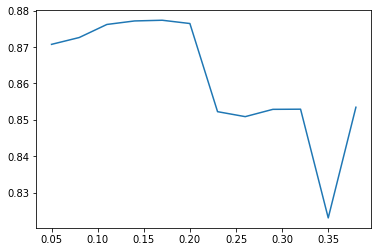

In [183]:
plt.plot(Learning_rate,Geo2)

In [184]:
#best learning_rate is 0.1

### Failure probability prediction

In [203]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,learning_rate=0.1,\
                max_depth = 5, alpha = 10, n_estimators = 80)

In [205]:
y_pred = xg_reg.predict(X_test).round()
geo(y_test,y_pred)

0.8823753947304406

In [204]:
xg_reg.fit(X_res,y_res)
prob=gbc.predict_proba(X_test)

y_pred_prob = y_test.to_frame()

y_pred_prob['0']=prob[:,0]

y_pred_prob['1']=prob[:,1]

y_pred_prob.head()

,failure,0,1
34643,0,0.990131,0.009869
35832,0,0.977116,0.022884
67849,0,0.999459,0.000541
8409,0,0.966666,0.033334
95115,0,0.999476,0.000524


In [125]:
#param_test1 = {'n_estimators':range(1,50,5)}
##geo = []
##for param_test1 in param_test1:
#
#gsearch1 = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.001, \
#                                        min_samples_split=500,\
#                                        min_samples_leaf=50,\
#                                        max_depth=8,max_features='sqrt',\
#                                        subsample=0.8,random_state=10),\
#                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch1.fit(X_res,y_res)
##geo.append(geo(y_test, gsearch1.predict(X_test).round()))
#
#
#                    

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(1, 50, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [126]:
#gsearch1.best_params_,gsearch1.best_score_

({'n_estimators': 1}, 0.5)